# CNN for image classification en Keras

by [Fabio A. González](http://dis.unal.edu.co/~fgonza/), Universidad Nacional de Colombia


version 2.0, June 2019

 [Machine Learning 2019-1](https://fagonzalezo.github.io/ml-2019-1/)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). 

This tutorial is based on the Blog post from Francois Chollet ["Building powerful image classification models using very little data"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

## Download data

This is a dataset of images of cats and dogs that was extacted from this [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats/data). 

The file can be manually downloaded from [here](https://drive.google.com/file/d/1Ys08yalsbM29fvvPhyDxv-SV7TBg3VxK/view?usp=sharing)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1Ys08yalsbM29fvvPhyDxv-SV7TBg3VxK'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])

     |████████████████████████████████| 993kB 2.8MB/s 


After downloading the file, we uncompress it*

In [0]:
!unzip cnn_data.zip > /dev/null


This creates the folder `data`:

In [0]:
!ls -la


total 54748
drwxr-xr-x 1 root root     4096 Jun 12 13:53 .
drwxr-xr-x 1 root root     4096 Jun 12 13:52 ..
-rw-r--r-- 1 root root     2540 Jun 12 13:53 adc.json
-rw-r--r-- 1 root root 56025080 Jun 12 13:53 cnn_data.zip
drwxr-xr-x 1 root root     4096 Jun 12 13:53 .config
drwxr-xr-x 4 root root     4096 Jul  5  2018 data
drwxrwxr-x 3 root root     4096 Jul  5  2018 __MACOSX
drwxr-xr-x 1 root root     4096 May 31 16:17 sample_data


The following code loads and show an image from the dataset:

Using TensorFlow backend.


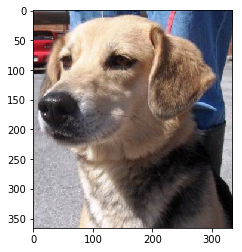

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('data/train/dog/dog.125.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
plt.imshow(img)

## Data augmentation

The goal of *data augmentation* is to extend the training data set by applying different transformations to the original images. The transformation include: rotations, translations, scale change, etc. This is done by the `ImageDataGenerator` class.

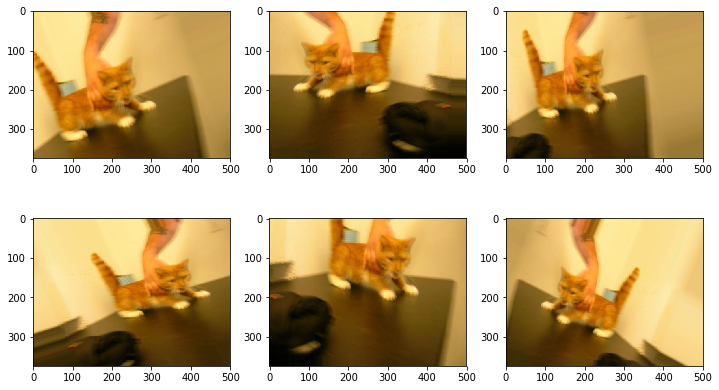

In [0]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cat/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, _, _)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, _, _)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
plt.figure(figsize=(12,7))
for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 6:
        break  # otherwise the generator would loop indefinitely
    plt.subplot(2,3,i)
    plt.imshow(batch[0]/255)
plt.show()

## Conv Net for Dog-Cat discrimination

Training variables

In [0]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 400
epochs = 50
batch_size = 16

The convolutional network model

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxP

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [0]:
epochs = 10
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
125/125 [==============================] - 19s 151ms/step - loss: 0.6987 - acc: 0.5335 - val_loss: 0.9140 - val_acc: 0.5000
Epoch 2/10
125/125 [==============================] - 14s 109ms/step - loss: 0.6575 - acc: 0.6300 - val_loss: 0.6415 - val_acc: 0.6375
Epoch 3/10
125/125 [==============================] - 14s 109ms/step - loss: 0.6343 - acc: 0.6465 - val_loss: 0.6163 - val_acc: 0.6650
Epoch 4/10
125/125 [==============================] - 14s 109ms/step - loss: 0.6094 - acc: 0.6810 - val_loss: 0.6316 - val_acc: 0.6175
Epoch 5/10
125/125 [==============================] - 14s 109ms/step - loss: 0.5814 - acc: 0.6975 - val_loss: 0.5976 - val_acc: 0.6775
Epoch 6/10
125/125 [==============================] - 14s 109ms/step - loss: 0.5687 - acc: 0.7110 - val_loss: 0.5889 - val_acc: 0.7050
Epoch 7/10
125/125 [==============================] - 14s 110ms/step - loss: 0.5552 - acc: 0.7320 - val_loss: 0.8061 - val_acc: 0.6250
Epoch 8

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7569407947958546004
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10484595864693557017
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7168470919607631955
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5937932485261196769
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
!nvidia-smi

Wed Jun 12 13:56:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   1343MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Testing the classifier

We will use the validation generator to generate one batch of samples and we'll pass them to the model

[[1.         0.41342703]
 [0.         0.2764287 ]
 [1.         0.81556284]
 [1.         0.7141301 ]
 [1.         0.6104854 ]
 [1.         0.7364093 ]
 [0.         0.44715017]
 [1.         0.37216115]
 [1.         0.39160216]
 [0.         0.46424416]
 [0.         0.2132169 ]
 [1.         0.62881196]
 [0.         0.61195   ]
 [0.         0.4175159 ]
 [1.         0.38383588]
 [1.         0.8724766 ]]


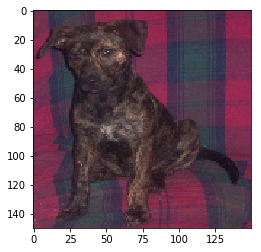

In [0]:
import numpy as np
for x_batch, y_batch in validation_generator:
  plt.imshow(x_batch[0])
  print(np.stack((y_batch, model.predict_proba(x_batch)[:,0])).T)
  break

## Transfer Learning

We will use a pretrained image classification model from Keras. They are documented [here](https://keras.io/applications/)

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 128, 128

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 400
epochs = 50
batch_size = 16

datagen = ImageDataGenerator(rescale=1. / 255)

# build the MobileNet network
model = applications.MobileNet(include_top=False, weights='imagenet'
                               , input_shape=(img_width, img_height, 3))

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_train = model.predict_generator(
    generator, nb_train_samples // batch_size)
np.save('bottleneck_features_train.npy',
        bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_validation = model.predict_generator(
    generator, nb_validation_samples // batch_size)
np.save('bottleneck_features_validation.npy',
        bottleneck_features_validation)

Using TensorFlow backend.
W0701 13:35:41.131170 140645539977088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 13:35:41.174314 140645539977088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 13:35:41.185559 140645539977088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 13:35:41.226449 140645539977088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 

17227776/17225924 [==============================] - 3s 0us/step


FileNotFoundError: ignored

In [0]:
bottleneck_features_train.shape

(2000, 4, 4, 1024)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [0]:
train_data = np.load('bottleneck_features_train.npy')
train_labels = np.array(
    [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = np.array(
    [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

model_1 = Sequential()
model_1.add(Flatten(input_shape=train_data.shape[1:]))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

model_1.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model_1.save_weights(top_model_weights_path)

Train on 2000 samples, validate on 400 samples
Epoch 1/50
2000/2000 [==============================] - 1s 728us/step - loss: 1.1369 - acc: 0.9000 - val_loss: 0.5720 - val_acc: 0.9575
Epoch 2/50
2000/2000 [==============================] - 1s 376us/step - loss: 0.5931 - acc: 0.9500 - val_loss: 0.7142 - val_acc: 0.9425
Epoch 3/50
2000/2000 [==============================] - 1s 372us/step - loss: 0.4097 - acc: 0.9650 - val_loss: 0.1633 - val_acc: 0.9750
Epoch 4/50
2000/2000 [==============================] - 1s 369us/step - loss: 0.4113 - acc: 0.9685 - val_loss: 0.2233 - val_acc: 0.9750
Epoch 5/50
2000/2000 [==============================] - 1s 382us/step - loss: 0.3260 - acc: 0.9730 - val_loss: 0.1549 - val_acc: 0.9825
Epoch 6/50
2000/2000 [==============================] - 1s 373us/step - loss: 0.1722 - acc: 0.9840 - val_loss: 0.1639 - val_acc: 0.9850
Epoch 7/50
2000/2000 [==============================] - 1s 382us/step - loss: 0.2578 - acc: 0.9790 - val_loss: 0.2318 - val_acc: 0.9775
E

In [0]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 4,194,817
Trainable params: 4,194,817
Non-trainable params: 0
_________________________________________________________________


In [0]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

for x_batch, y_batch in validation_generator:
  print(np.stack((y_batch, model_1.predict_proba(model.predict(x_batch))[:,0])).T)
  break


Found 400 images belonging to 2 classes.
[[0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
